In [78]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
plt.ion()   # interactive mode
from PIL import Image
from torch.autograd import Variable
import io





In [4]:
data_transforms = {
    'humerus': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'humerus_v': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [5]:
data_dir = "/Users/sidgupta/Documents/mura"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['humerus', 'humerus_v']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['humerus', 'humerus_v']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['humerus', 'humerus_v']}
class_names = image_datasets['humerus'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class_names

['abnormal', 'normal']

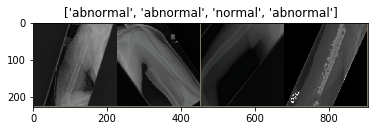

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['humerus']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
classes

tensor([0, 0, 1, 0])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['humerus', 'humerus_v']:
            if phase == 'humerus':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'humerus'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'humerus':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'humerus_v' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/9
----------
humerus Loss: 0.8314 Acc: 0.5943
humerus_v Loss: 0.7468 Acc: 0.6840

Epoch 1/9
----------
humerus Loss: 0.8777 Acc: 0.5865
humerus_v Loss: 0.8575 Acc: 0.5764

Epoch 2/9
----------
humerus Loss: 0.7899 Acc: 0.6132
humerus_v Loss: 0.7095 Acc: 0.7118

Epoch 3/9
----------
humerus Loss: 0.8081 Acc: 0.6226
humerus_v Loss: 0.6503 Acc: 0.6910

Epoch 4/9
----------
humerus Loss: 0.7170 Acc: 0.6517
humerus_v Loss: 0.5082 Acc: 0.8021

Epoch 5/9
----------
humerus Loss: 0.6644 Acc: 0.6832
humerus_v Loss: 0.6959 Acc: 0.6354

Epoch 6/9
----------
humerus Loss: 0.6544 Acc: 0.6753
humerus_v Loss: 0.5008 Acc: 0.7639

Epoch 7/9
----------
humerus Loss: 0.5395 Acc: 0.7335
humerus_v Loss: 0.4707 Acc: 0.7882

Epoch 8/9
----------
humerus Loss: 0.5358 Acc: 0.7296
humerus_v Loss: 0.4422 Acc: 0.8125

Epoch 9/9
----------
humerus Loss: 0.5211 Acc: 0.7351
humerus_v Loss: 0.4269 Acc: 0.8056

Training complete in 73m 36s
Best val Acc: 0.812500


In [2]:
acc = model_ft.history['humerus Acc']
val_acc = model_ft.history['humerus_v Acc']
loss = model_ft.history['humerus Loss']
val_loss = model_ft.history['humerus_v Loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'model_ft' is not defined

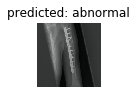

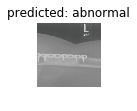

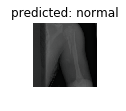

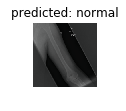

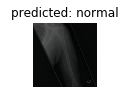

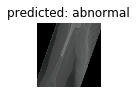

In [11]:
visualize_model(model_ft)

In [43]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [44]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
humerus Loss: 0.7778 Acc: 0.5912
humerus_v Loss: 0.4992 Acc: 0.7639

Epoch 1/24
----------
humerus Loss: 0.8187 Acc: 0.5873
humerus_v Loss: 0.5103 Acc: 0.7465

Epoch 2/24
----------


KeyboardInterrupt: 

In [20]:
torch.save(model_conv, "/Users/sidgupta/Documents/mura/densenet")

In [46]:
finalconv_name = 'layer4'

In [75]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize(224,224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


img_pil=Image.open('/Users/sidgupta/Documents/mura/humerus/abnormal/abnormal_HUMERUS_patient1464_study1_image1.png')#.convert('LA')
#img_array = cv2.imread('/Users/sidgupta/Documents/mura/humerus/abnormal/abnormal_HUMERUS_patient1464_study1_image1.png' ,cv2.IMREAD_GRAYSCALE)  # convert to array

print(img_pil)
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)



<PIL.PngImagePlugin.PngImageFile image mode=L size=443x512 at 0x120661B70>


ValueError: unknown resampling filter